# Sialorrhea  Analysis

# Part1: analysis with mouth features
Read Files

In [38]:
#read csv files for getting the data
import csv
import os
import sys
import pandas as pd
import numpy as np

#read the csv file
def read_csv_features(file):
    df = pd.read_csv(file)
    df['user'] = df['0'].str.split('_').str[0]  
    df['user'] = df['user'].str.split('.').str[0]
    df = df.drop(columns=['0'])  
    #remove rows with same user
    df.set_index('user', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df
happpy_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\mouth_features_max_happiness.csv'
happy_df = read_csv_features(happpy_csv)
#read the csv file
neutral_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\mouth_features_true_neutral.csv'
neutral_df = read_csv_features(neutral_csv)

FileNotFoundError: [Errno 2] No such file or directory: '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\features_10_max_happiness_2.csv'

In [39]:
sialorreha_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\saliva.csv'
map_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\map_id.csv'
saliva_df = pd.read_csv(sialorreha_csv)
saliva_df.set_index('ID', inplace=True)
map_df = pd.read_csv(map_csv)

saliva_df = saliva_df.join(map_df.set_index('Subjet ID'), on='ID')
#remove nan rows where 'ROMP_saliva_Q_done' is nan
saliva_df = saliva_df.dropna(subset=['ROMP_saliva_Q_done','Booth ID'])   
saliva_df = saliva_df[saliva_df['ROMP_saliva_Q_done'] == 'Y']
saliva_df.set_index('Booth ID', inplace=True)
saliva_df.drop(columns=['ROMP_saliva_Q_done','Date','Unnamed: 13'], inplace=True)
saliva_df.index = saliva_df.index.astype(int).astype(str)


Analysis of correlation between features

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

#correct column name remove after the first dot
saliva_df.columns = saliva_df.columns.str.split('.').str[0]
# Compute the correlation matrix
correlation_matrix = saliva_df.corr()



# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Saliva DataFrame Correlation Heatmap')
plt.show()


ModuleNotFoundError: No module named 'seaborn'

In [41]:
def compute_features(df):
    sqrt_of_sums = np.sqrt(df.iloc[:, -2]**2 + df.iloc[:, -1]**2)

    # Divide all features by this value
    df = df.div(sqrt_of_sums, axis=0)

    # Drop the last two features
    df = df.iloc[:, :-2]
    return df

def compute_combined_features(happy_df, neutral_df):
    happy_df = compute_features(happy_df)
    neutral_df = compute_features(neutral_df)

    happy_df = happy_df.add_suffix('_happy')
    neutral_df = neutral_df.add_suffix('_neutral')

    # Combine the two dataframes
    combine_features_df = pd.concat([happy_df, neutral_df], axis=1, join='inner')
    return combine_features_df

combine_features_df = compute_combined_features(happy_df, neutral_df)

# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_df = combine_features_df.join(saliva_df, how='inner', rsuffix='_saliva')


In [42]:
#show difference indexes beteen merged and saliva
diff = saliva_df.index.difference(merged_df.index)
print(diff)

Index([], dtype='object')


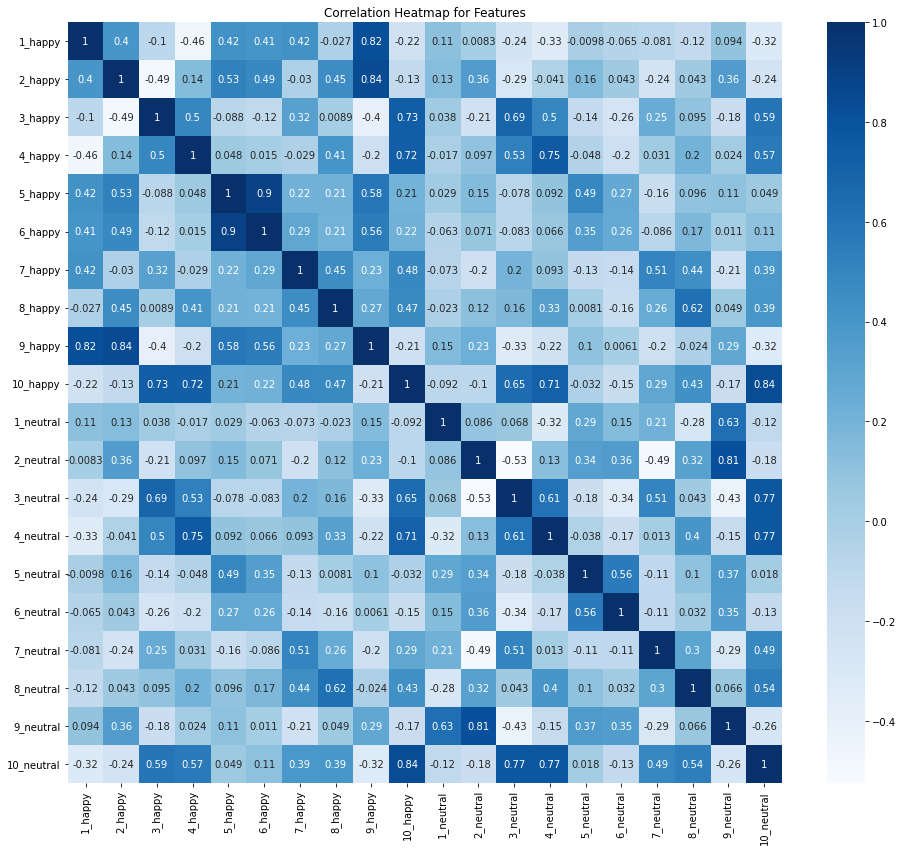

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Features')
plt.show()


First CCA with 9 components

In [44]:

import pandas as pd
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler

# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:,-9:])  # Features
X = scaler.fit_transform(merged_df.iloc[:,:-10])  # Questionnaire results

# Initialize CCA with the number of components is the smaller number of columns in the two datasets
n_components = min(saliva_df.shape[1], combine_features_df.shape[1])
n_components=5
cca = CCA(n_components=9)

# Fit CCA
cca.fit(X, Y)

# Transform the data (this step computes the canonical variables)
X_c, Y_c = cca.transform(X, Y)


cca.coef_

array([[-2.63973780e-01,  1.61552391e-02,  6.91433499e-01,
         8.41600093e-01, -2.03142060e-01, -8.70236438e-01,
        -3.82279483e-02,  1.42488877e-01,  1.02948341e-01],
       [ 1.77109609e+00,  1.54931518e+00,  8.84770097e-01,
         3.36880810e-01,  5.50582825e-01,  4.19545851e-01,
         4.61529353e-01,  9.53594162e-01,  1.42360980e+00],
       [ 5.03122352e-01, -2.49026358e-02,  1.40586233e-01,
        -1.96934200e-01,  1.46352655e-01,  8.37382231e-01,
         2.23111655e-01,  5.25551670e-02,  1.97647306e-01],
       [-1.72885107e+00, -1.33037860e+00,  7.14232261e-02,
         2.07258012e-01, -8.20772630e-01, -5.96969010e-01,
         1.85090203e-01, -5.53338189e-01, -1.08947742e+00],
       [-4.29953877e-01, -5.04245288e-01,  2.57103116e-01,
        -3.20788369e-02, -4.42512196e-01, -1.89034678e-01,
         2.35537458e-01, -2.48661958e-02, -3.40653390e-01],
       [ 3.99460751e-01,  5.39391718e-02, -9.26512748e-02,
         2.74494307e-01,  2.41380684e-01,  2.103652

Pearson t-test between features and questions

In [45]:
import pandas as pd
from scipy.stats import pearsonr


# Create an empty DataFrame to store the results
results_df = pd.DataFrame(columns=['Feature', 'Saliva_Column', 'Correlation', 'P-Value'])

# Iterate over each feature in combine_features_df
for feature in combine_features_df.columns:
    # Iterate over each column in saliva_df
    for column in saliva_df.columns:
        # Calculate the Pearson correlation coefficient and the p-value
        correlation, p_value = pearsonr(merged_df[feature], merged_df[column])
        
        # Append the results to the results_df
        results_df = results_df.append({'Feature': feature, 'Saliva_Column': column, 'Correlation': correlation, 'P-Value': p_value}, ignore_index=True)

# Optionally, you can filter the results to only keep significant correlations
significant_results_df = results_df[results_df['P-Value'] < 0.05]

print(significant_results_df)


        Feature Saliva_Column  Correlation   P-Value
35      4_happy            Q6    -0.304902  0.026423
62      7_happy            Q3    -0.342884  0.011957
72      8_happy            Q3    -0.407163  0.002480
75      8_happy            Q6    -0.295127  0.031924
79      8_happy         Total    -0.305017  0.026363
92     10_happy            Q3    -0.280227  0.042118
95     10_happy            Q6    -0.316665  0.020878
104   1_neutral            Q5     0.290110  0.035099
107   1_neutral            Q8     0.280225  0.042119
132   4_neutral            Q3    -0.281282  0.041317
134   4_neutral            Q5    -0.317685  0.020447
135   4_neutral            Q6    -0.419288  0.001778
137   4_neutral            Q8    -0.434835  0.001139
138   4_neutral            Q9    -0.340941  0.012481
139   4_neutral         Total    -0.343884  0.011695
172   8_neutral            Q3    -0.290793  0.034651
175   8_neutral            Q6    -0.405190  0.002615
177   8_neutral            Q8    -0.351782  0.

In [46]:
#save significant results to a csv file
significant_results_df.to_csv('significant_results_10feaure.csv', index=False)

Show CCA Coeficients

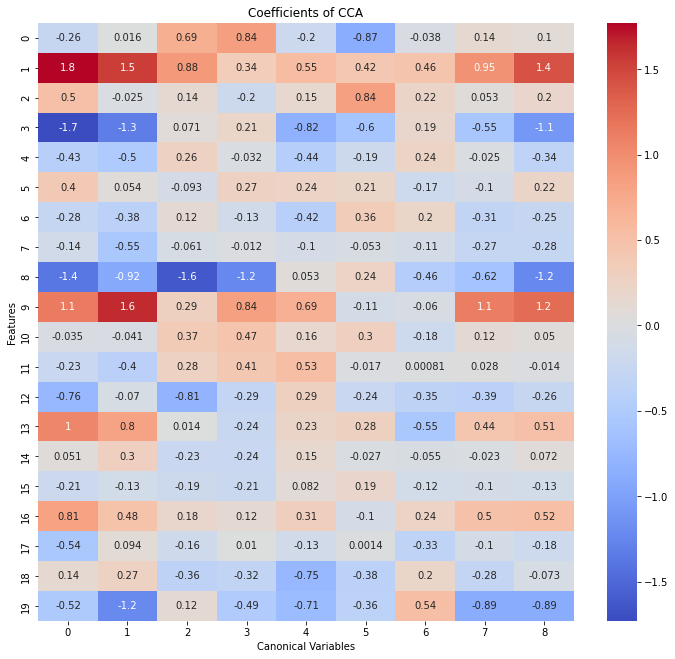

In [47]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming cca is your CCA object
plt.figure(figsize=(12, 11))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('Canonical Variables')
plt.ylabel('Features')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()


SHow CCA Weights

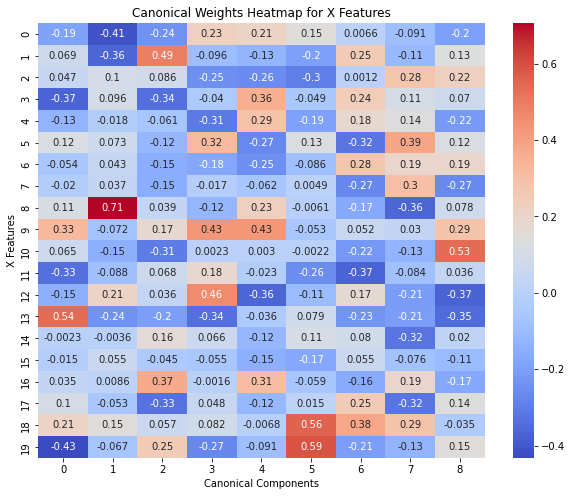

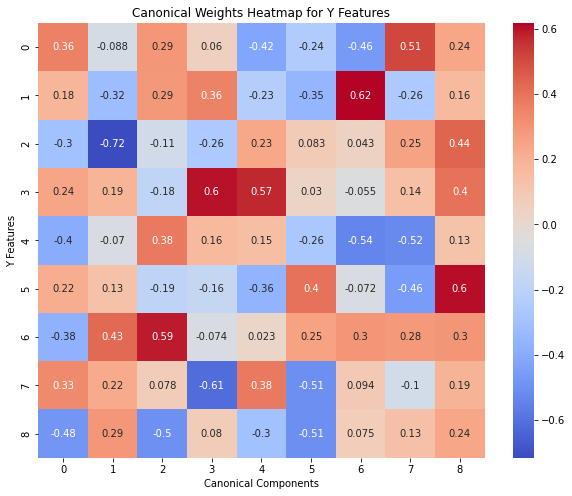

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

weights_X = cca.x_weights_  # Canonical weights for features in X
weights_Y = cca.y_weights_  # Canonical weights for features in Y

# Creating a heatmap for X weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_X, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for X Features')
plt.xlabel('Canonical Components')
plt.ylabel('X Features')
plt.show()

# Repeat similarly for Y weights
plt.figure(figsize=(10, 8))
sns.heatmap(weights_Y, annot=True, cmap="coolwarm")
plt.title('Canonical Weights Heatmap for Y Features')
plt.xlabel('Canonical Components')
plt.ylabel('Y Features')
plt.show()



# Part2: Applying CCA with Cross Validation and bootstrap
The results below clearly demonstrate that there is variation in the coefficients, pointing to a possible issue with either the number of data points, the number of features, or even the number of components.



In [15]:
from sklearn.cross_decomposition import CCA
from sklearn.decomposition import PCA
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_df.iloc[:, -9:])  # Features
X = scaler.fit_transform(merged_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca = PCA(n_components=0.95)

X = pca.fit_transform(X)

Canonical Correlations for fold: [ 0.20481457  0.63838883 -0.15021506  0.40331952  0.10993158 -0.19864374
  0.30308959 -0.04674308  0.14241543]
Canonical Correlations for fold: [-0.28381191  0.23479241 -0.08413511  0.14157069  0.330852   -0.40152685
  0.05489875 -0.03611756 -0.19734721]
Canonical Correlations for fold: [ 0.64951598  0.178628   -0.25462742  0.25957468  0.0718784  -0.59870589
 -0.11045062  0.39170559  0.35653598]
Canonical Correlations for fold: [-0.09413993  0.09944778 -0.30175103  0.37039884  0.04609551  0.04681708
 -0.01679426  0.16177942 -0.41979461]
Canonical Correlations for fold: [ 0.21611367  0.35572017  0.91227808 -0.04342674  0.39769351 -0.43555185
 -0.43236471  0.17965173  0.56277676]
Average correlations across folds: [ 0.13849848  0.30139544  0.02430989  0.2262874   0.1912902  -0.31752225
 -0.04032425  0.13005522  0.08891727]
Standard deviation of correlations across folds: [0.31749883 0.18804595 0.45051716 0.16318037 0.14424959 0.22222837
 0.23923527 0.1617

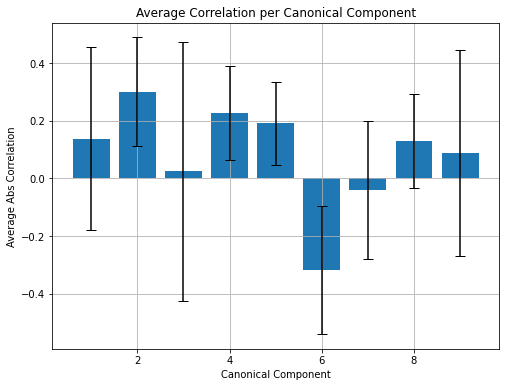

In [16]:
import pandas as pd

from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, StratifiedKFold
import numpy as np




# Define the number of components for CCA
n_components = min(Y.shape[1], X.shape[1])

# Initialize KFold
kf = KFold(n_splits=5, shuffle=True, random_state=22)

# To store correlations for each fold
correlations = []

# Cross-validation
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    
    # Initialize and fit CCA within the fold
    cca = CCA(n_components=n_components)
    cca.fit(X_train, Y_train)
    
    # Transform the data (this step computes the canonical variables)
    X_c, Y_c = cca.transform(X_test, Y_test)
    
    # Calculate and store the correlation for the current fold
    corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components)
    print(f"Canonical Correlations for fold: {corr}")
    correlations.append(corr)

# Aggregate results
average_correlations = np.mean(correlations, axis=0)
print(f"Average correlations across folds: {average_correlations}")

# Optionally, also calculate the standard deviation to estimate variability
std_correlations = np.std(correlations, axis=0)
print(f"Standard deviation of correlations across folds: {std_correlations}")

# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

### Using Bootstrap and compare loadings


Average correlations across bootstrap samples: [0.90478619 0.82868909 0.74825505 0.6596621  0.56324985]
Standard deviation of correlations across bootstrap samples: [0.0349077  0.04695545 0.05342894 0.05926926 0.06298606]


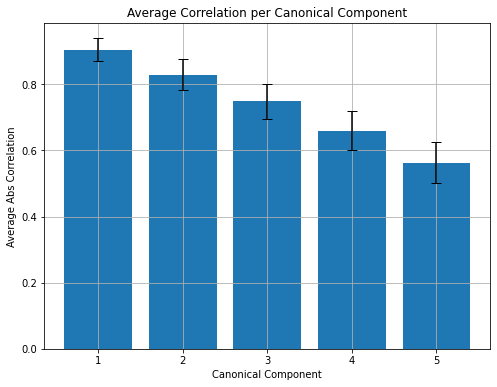

In [17]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample


n_bootstraps = 1000
n_components = 5

def bootstrap_analysis(X,Y, n_components, n_bootstraps):
    # Store bootstrapped loadings
    bootstrapped_loadings_x = np.zeros((n_bootstraps, X.shape[1], n_components))
    bootstrapped_loadings_y = np.zeros((n_bootstraps, Y.shape[1], n_components))

    correlations = []
    for i in range(n_bootstraps):
        # Resample X and Y with replacement
        X_resampled, Y_resampled = resample(X, Y)
        
        # Fit CCA to the resampled data
        cca = CCA(n_components=n_components)
        cca.fit(X_resampled, Y_resampled)
        
        # Store the loadings
        bootstrapped_loadings_x[i] = cca.x_loadings_
        bootstrapped_loadings_y[i] = cca.y_loadings_
        
        # Transform the data (this step computes the canonical variables)
        X_c, Y_c = cca.transform(X_resampled, Y_resampled)
        
        # Calculate and store the correlation for the current fold
        corr = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_components)
        correlations.append(corr)

    # Aggregate results
    average_correlations = np.mean(correlations, axis=0)
    print(f"Average correlations across bootstrap samples: {average_correlations}")

    # Optionally, also calculate the standard deviation to estimate variability
    std_correlations = np.std(correlations, axis=0)
    print(f"Standard deviation of correlations across bootstrap samples: {std_correlations}")
    
    return average_correlations, std_correlations

average_correlations, std_correlations = bootstrap_analysis(X,Y,n_components, n_bootstraps)
# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

In [18]:
#Plot reasults
import seaborn as sns
import matplotlib.pyplot as plt

def show_loadings(loadings_x ,loadings_y):
    # Assuming mean_loadings_x is a numpy array of shape (n_components, n_variables)
    mean_loadings_x = loadings_x

    # Create a heatmap
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(mean_loadings_x, annot=True, cmap='viridis',
                    xticklabels=[f'Component {x+1}' for x in range(mean_loadings_x.shape[1])],
                    yticklabels=[f'PC {i+1}' for i in range(mean_loadings_x.shape[0])])

    ax.set_title('Heatmap of Loadings for X Variables')
    plt.xlabel('PC Components')
    plt.ylabel('Components')
    plt.show()

    #plot the heatmap for Y variables
    mean_loadings_y = loadings_y
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(mean_loadings_y, annot=True, cmap='viridis',
                    xticklabels=[f'Component {y+1}' for y in range(mean_loadings_y.shape[1])],
                    yticklabels=[f'Question {i+1}' for i in range(mean_loadings_y.shape[0])])

    ax.set_title('Heatmap of Loadings for Y Variables')
    plt.xlabel('Variables')
    plt.ylabel('Components')
    plt.show()


-0.9617620329018364


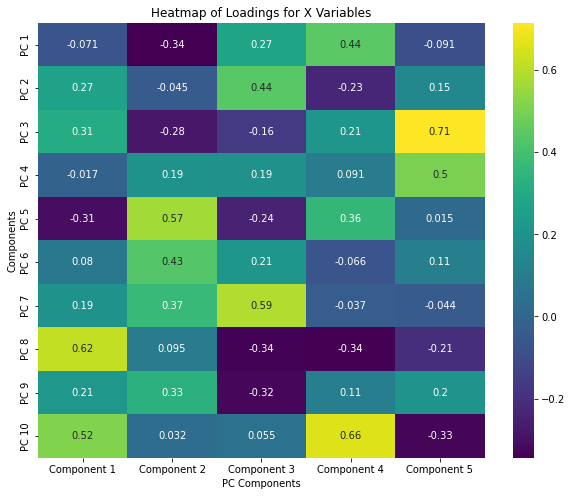

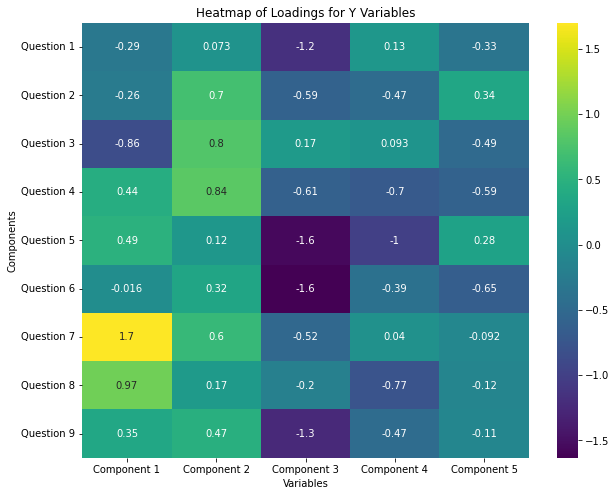

In [19]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X, Y)

#print cca score
print(cca.score(X,Y))
show_loadings(cca.x_loadings_, cca.y_loadings_)


# Scatter plots of commponents

Correlation for pair 1: 0.7991995976949252, P-value: 7.309185523900213e-13


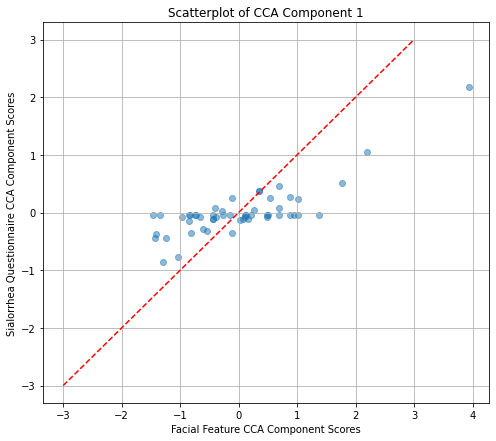

Correlation for pair 2: 0.6992970109208148, P-value: 5.72206833904869e-09


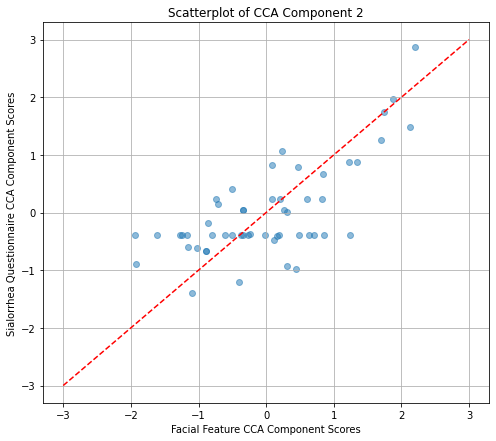

Correlation for pair 3: 0.5669841398577794, P-value: 9.584303257992606e-06


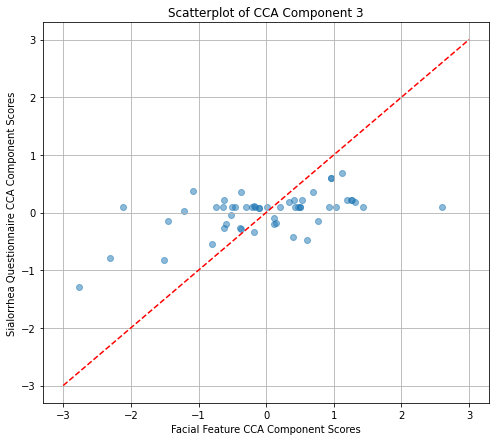

Correlation for pair 4: 0.497315296246597, P-value: 0.00015161503756853597


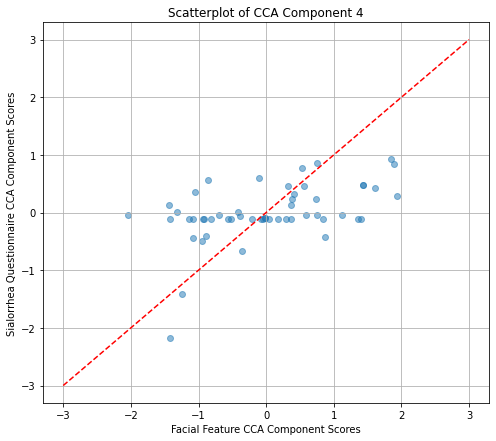

Correlation for pair 5: 0.41439076594834706, P-value: 0.002036515364521775


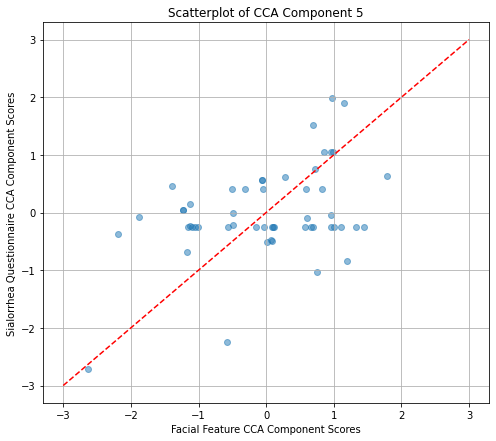

In [28]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()


CCA Weights

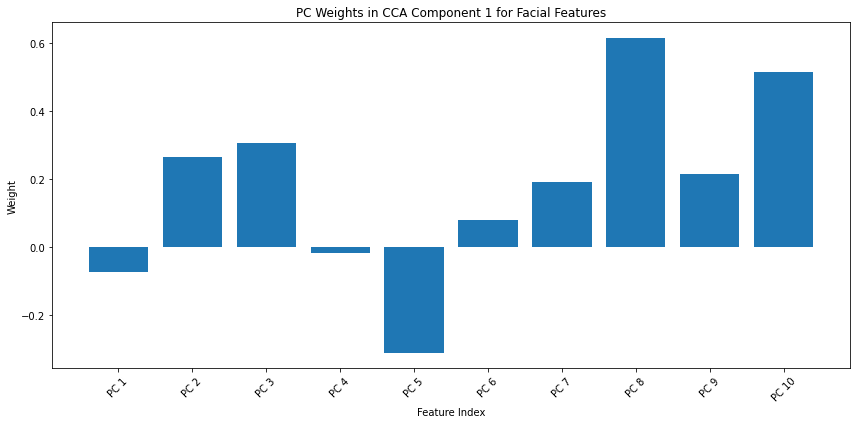

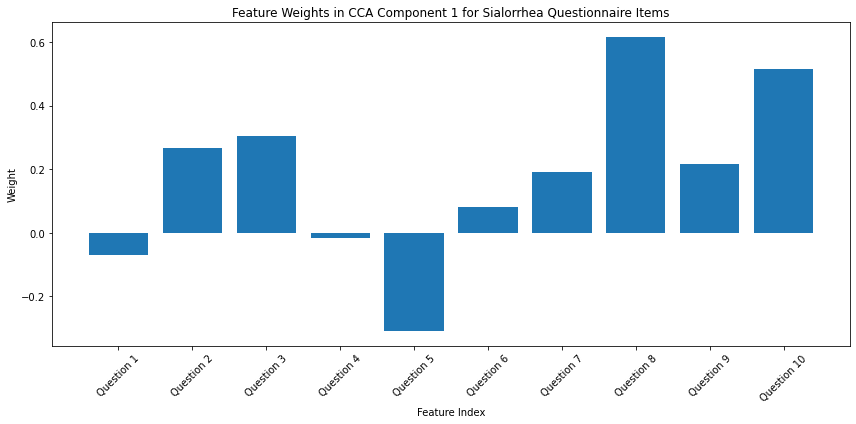

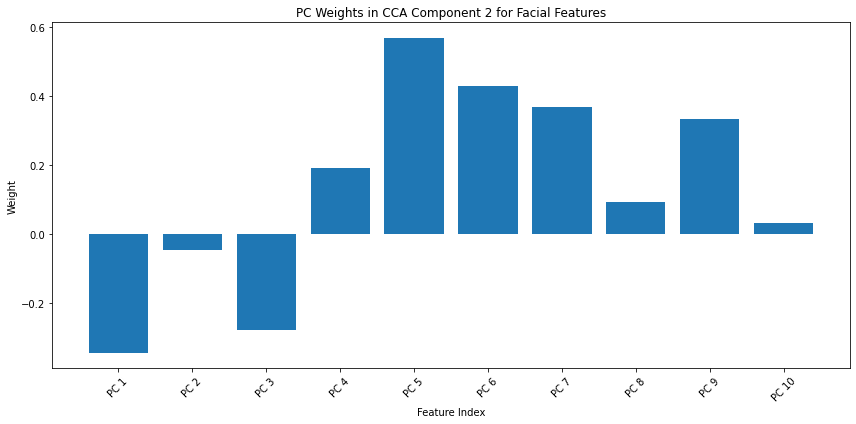

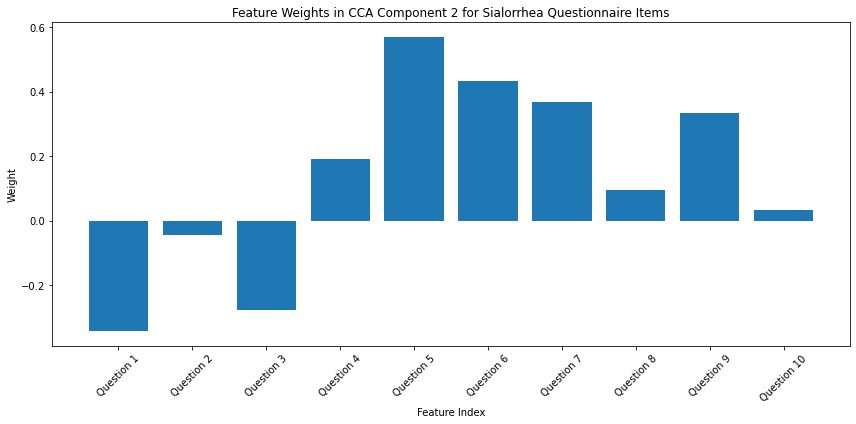

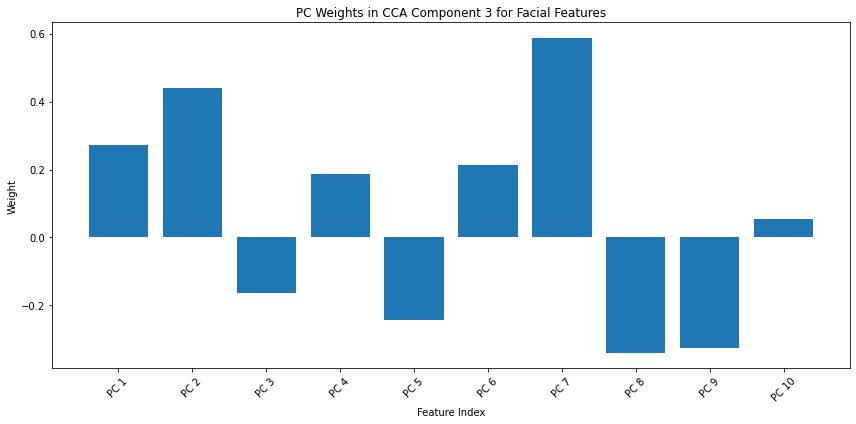

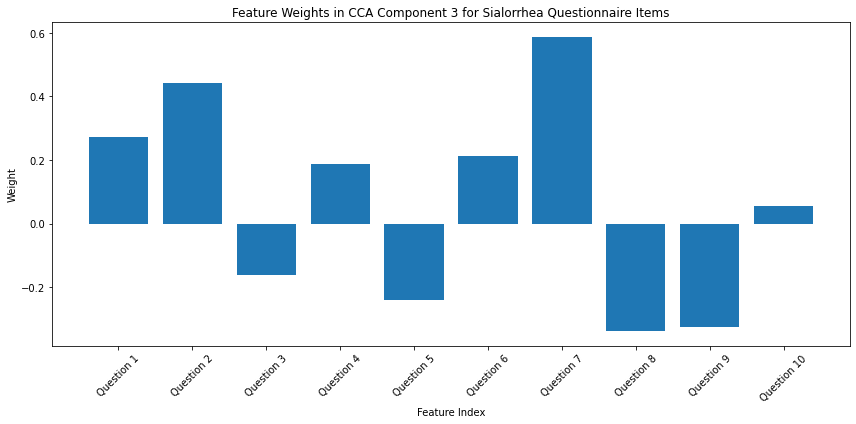

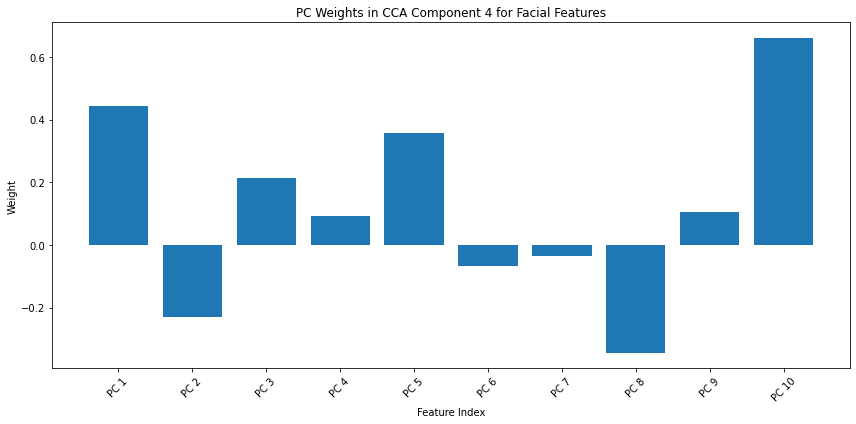

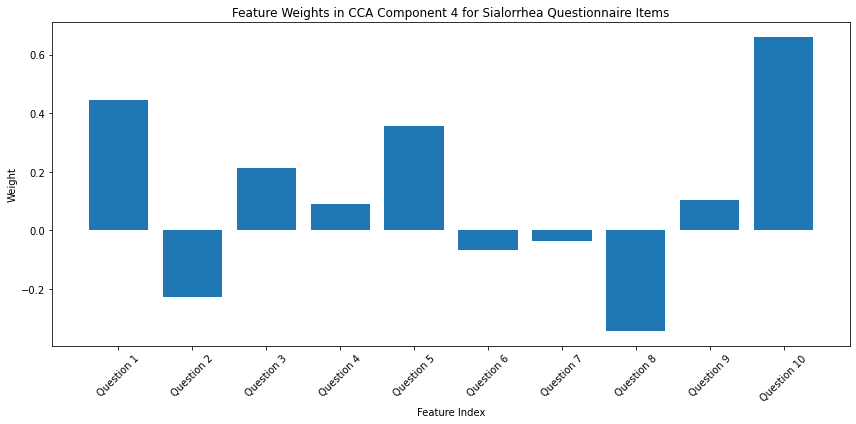

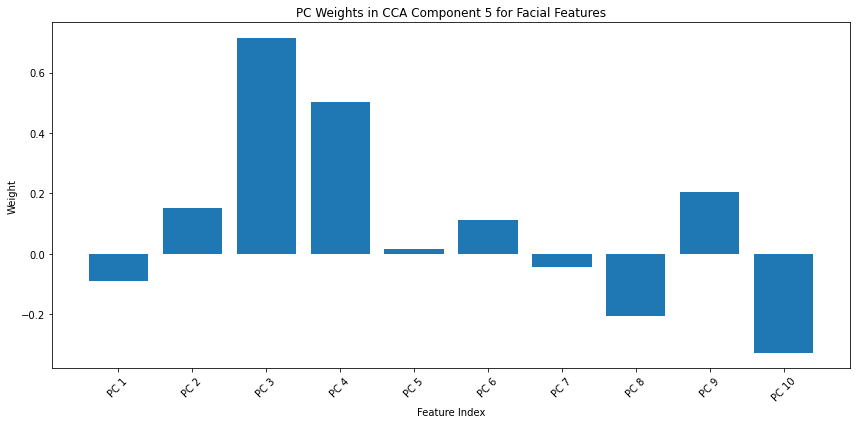

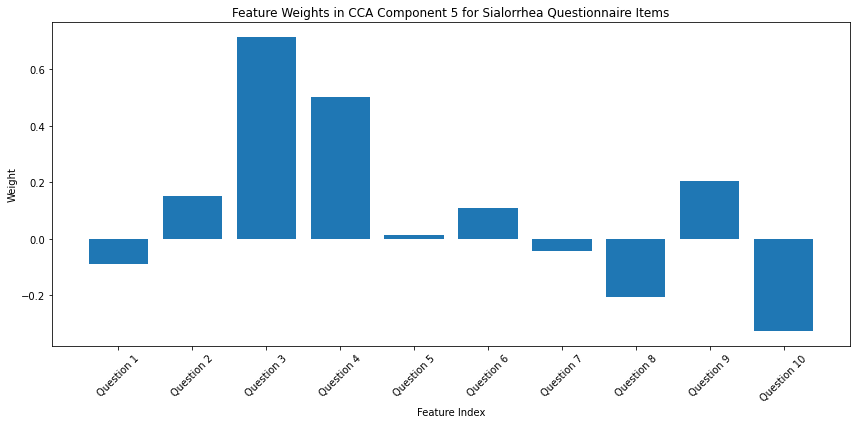

In [29]:
#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_weights_[:, component_index]
    weights_y = cca.x_weights_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()



### Analysis PCA Components

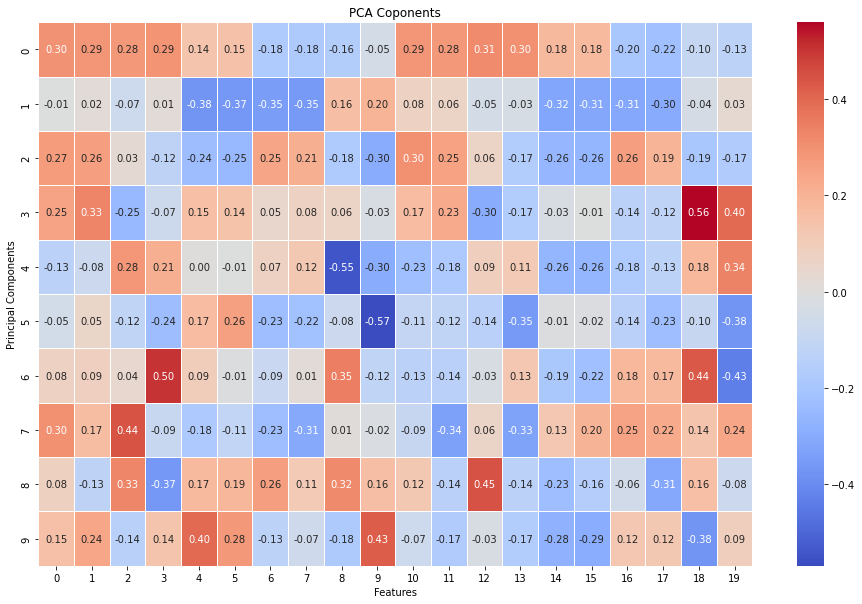

In [30]:
# Magnitude: A higher absolute value of a loading indicates that the variable strongly influences the principal component.
# Sign: The sign (positive or negative) indicates the direction of the influence. Variables with the same sign in a PC are directly related, while those with opposite signs are inversely related.

import seaborn as sns
#Evaluate PCA

import matplotlib.pyplot as plt

# Get the PCA loadings
pca_loadings = pca.components_

# Create a heatmap of the PCA loadings
plt.figure(figsize=(16, 10))
sns.heatmap(pca_loadings, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title('PCA Coponents')
plt.xlabel('Features')
plt.ylabel('Principal Components')
plt.show()


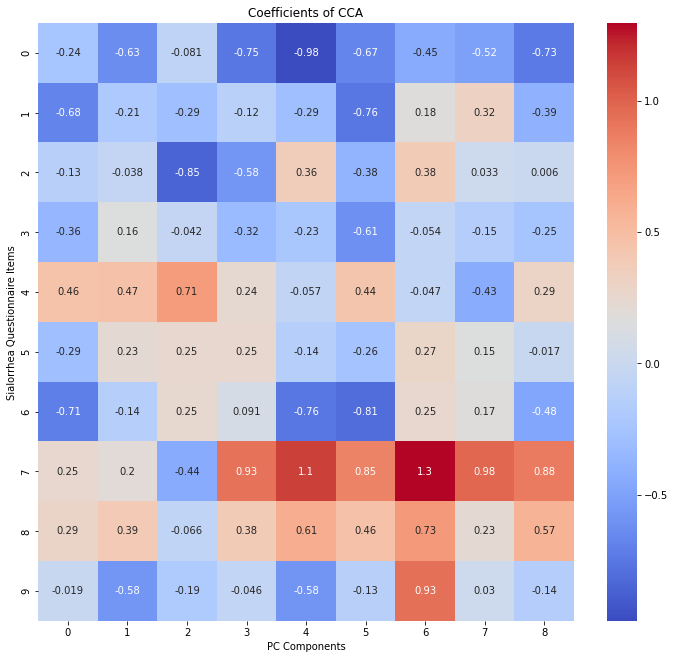

In [31]:
#The coefficients of the linear model such that Y is approximated as Y = X @ coef_.T + b.
# cca coeeficients
plt.figure(figsize=(12, 11))
coefficients = cca.coef_

# Create a heatmap
sns.heatmap(coefficients, cmap='coolwarm', annot=True)

# Add labels and title
plt.xlabel('PC Components')
plt.ylabel('Sialorrhea Questionnaire Items')
plt.title('Coefficients of CCA')

# Show the plot
plt.show()

## Part3: Try with Eye features


In [22]:
import pandas as pd
eye_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\eye_features_true_neutral.csv'
eye_neutral_df = read_csv_features(eye_features_csv)
eye_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\eye_features_max_happiness.csv'
eye_happy_df = read_csv_features(eye_features_csv)
combine_eye_features_df = compute_combined_features(eye_happy_df, eye_neutral_df)
# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_eye_df = combine_eye_features_df.join(saliva_df, how='inner', rsuffix='_saliva')

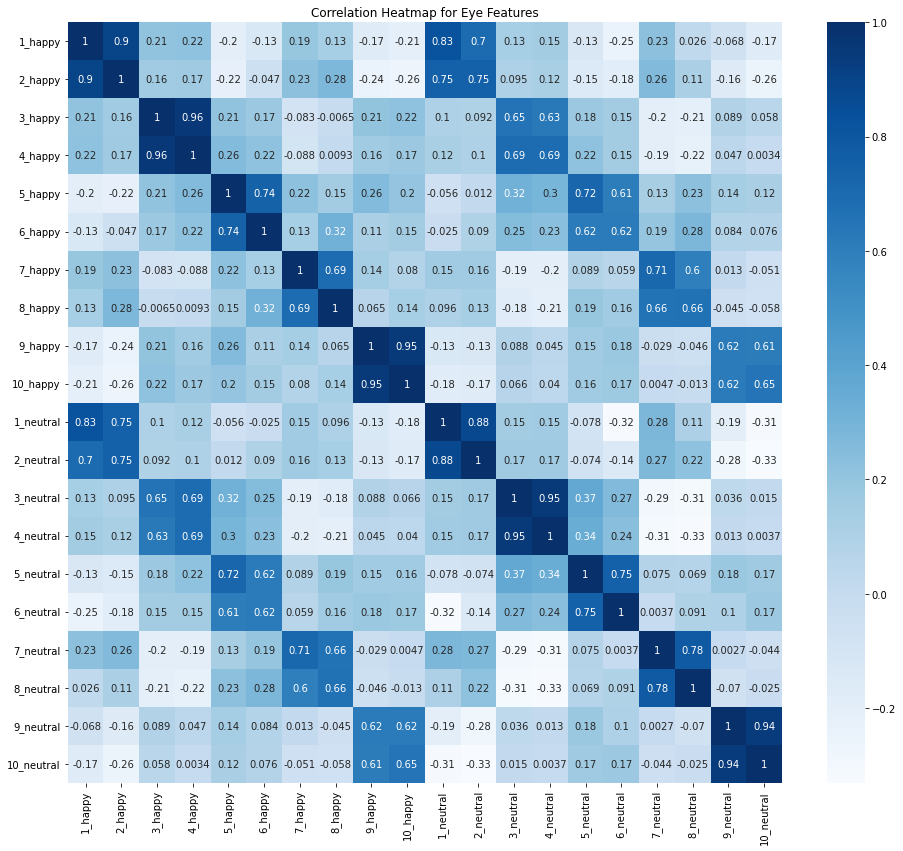

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_eye_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Eye Features')
plt.show()

In [24]:
#Define data
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_eye_df.iloc[:, -9:])  # Features
X_eye = scaler.fit_transform(merged_eye_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca_eye = PCA(n_components=0.95)

X_eye = pca_eye.fit_transform(X_eye)

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_decomposition\_pls.py:107: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


Average correlations across bootstrap samples: [0.91544776 0.85243741 0.77698658 0.68739422 0.58011451]
Standard deviation of correlations across bootstrap samples: [0.03211419 0.04211909 0.05218849 0.05879828 0.06514112]


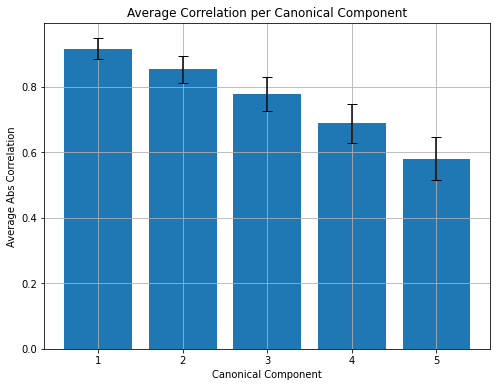

In [25]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



n_bootstraps = 1000
n_components = 5

average_correlations, std_correlations = bootstrap_analysis(X_eye,Y,n_components, n_bootstraps)
# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

In [26]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X_eye, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X_eye, Y)

Correlation for pair 1: 0.7985806297260635, P-value: 7.842611106871208e-13


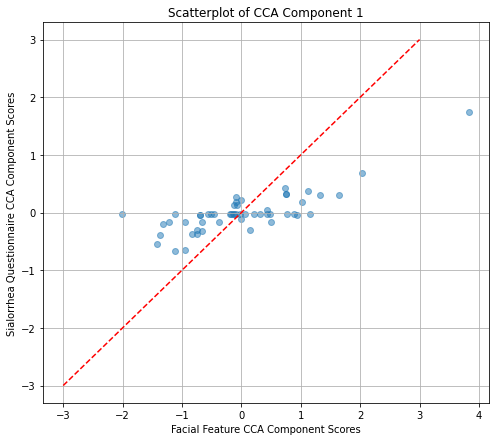

Correlation for pair 2: 0.7193148709230749, P-value: 1.2969429070526883e-09


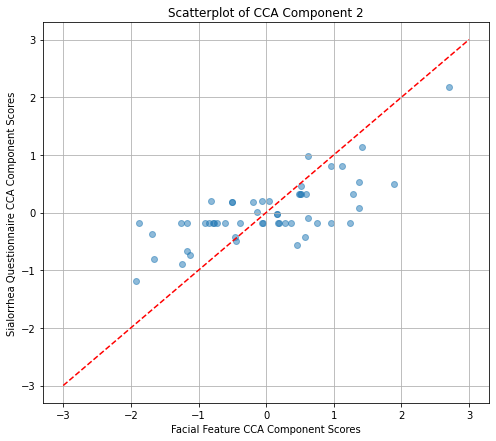

Correlation for pair 3: 0.6527303017591176, P-value: 1.1803589563320853e-07


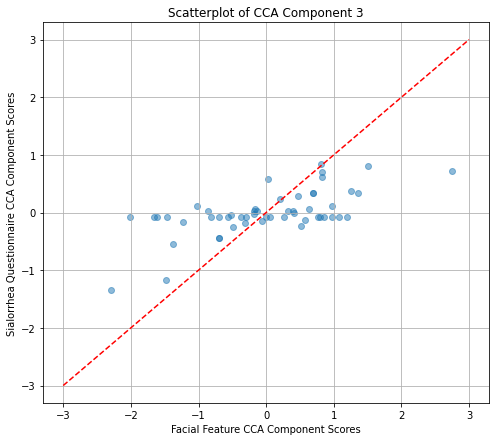

Correlation for pair 4: 0.5801390738391359, P-value: 5.290530766814829e-06


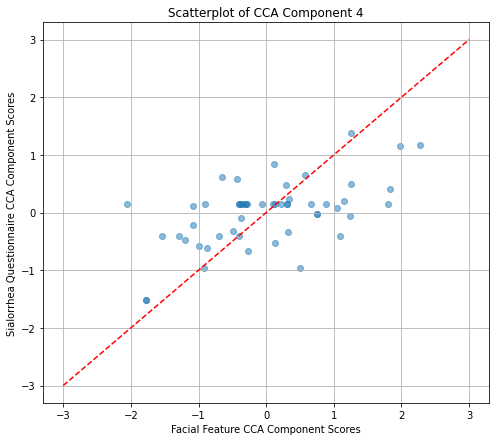

Correlation for pair 5: 0.45606903690970557, P-value: 0.0005990052355636362


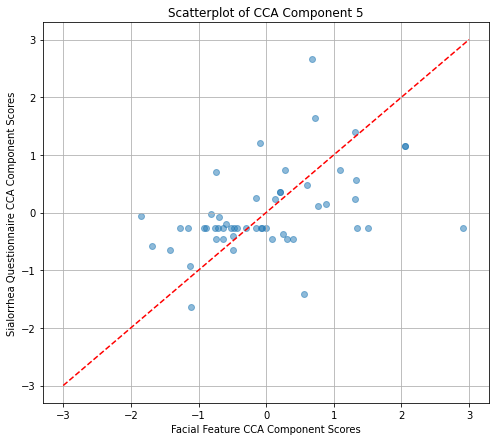

In [27]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()

CCA Score: -0.8963017206958452


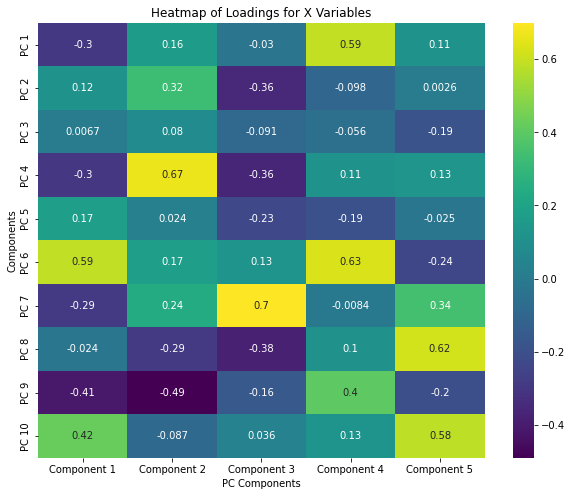

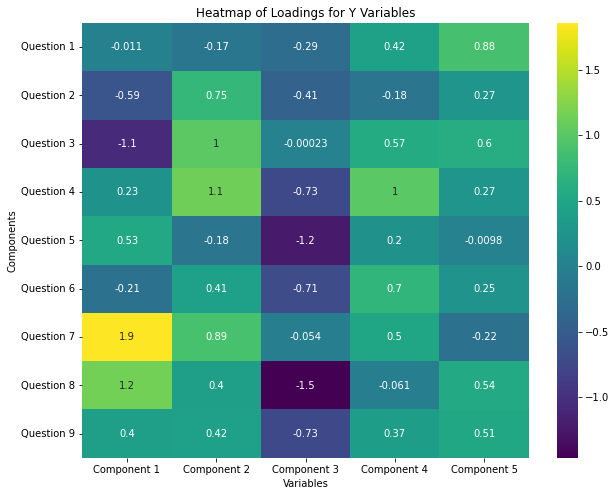

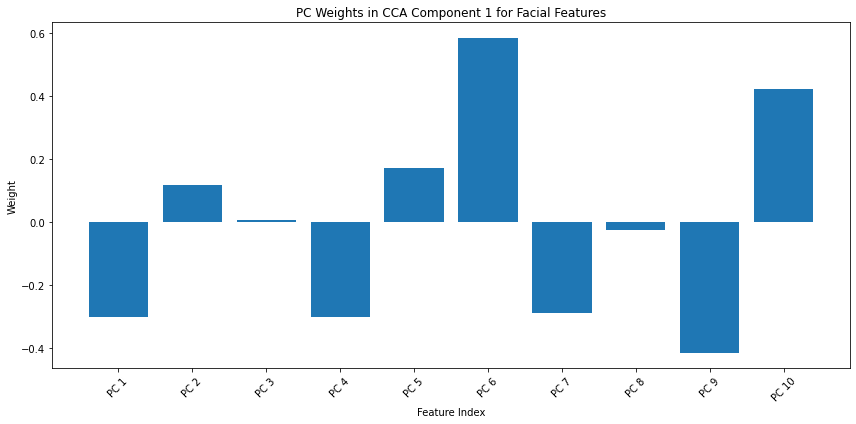

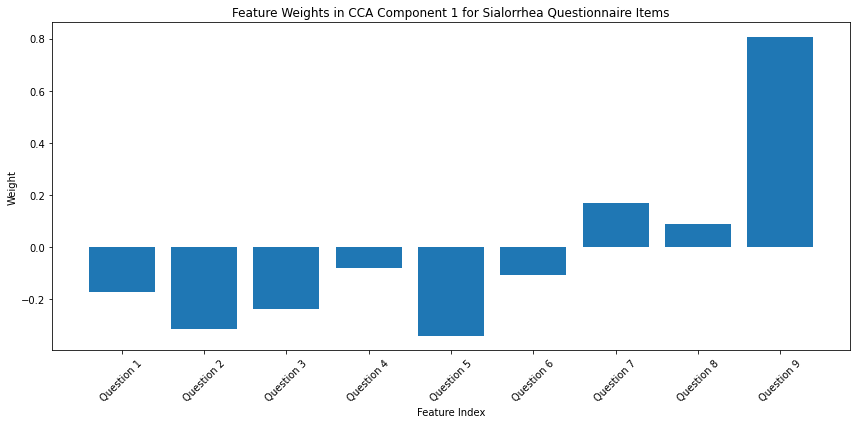

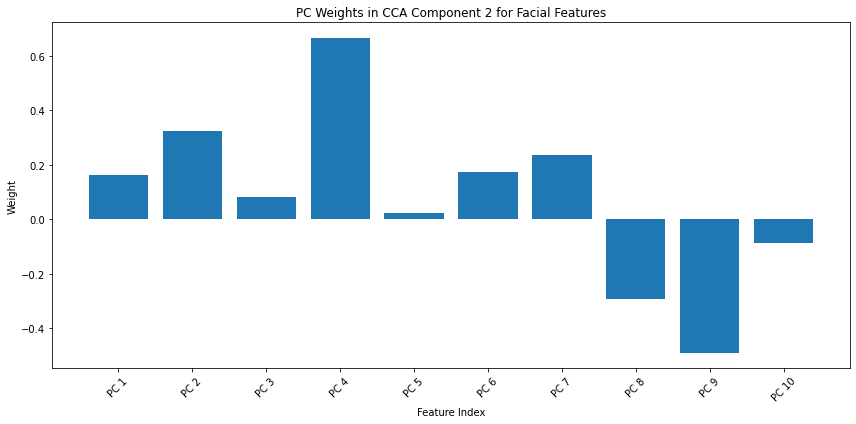

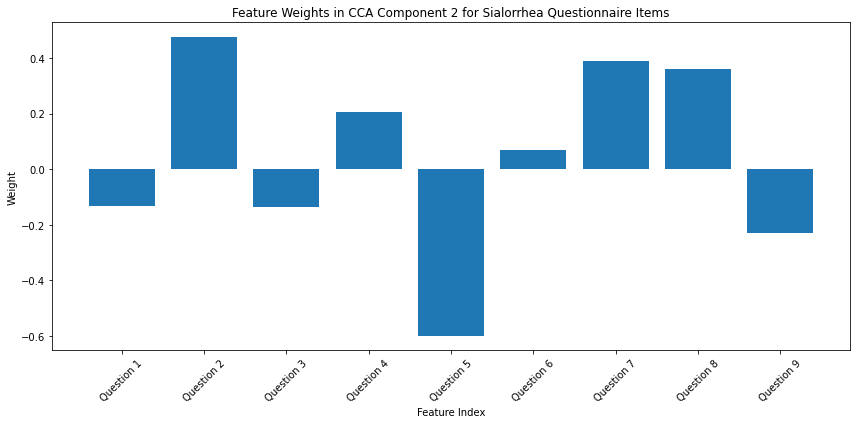

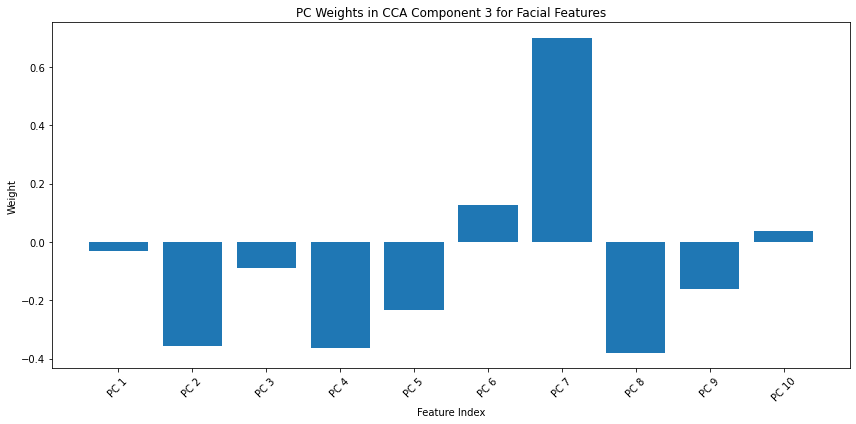

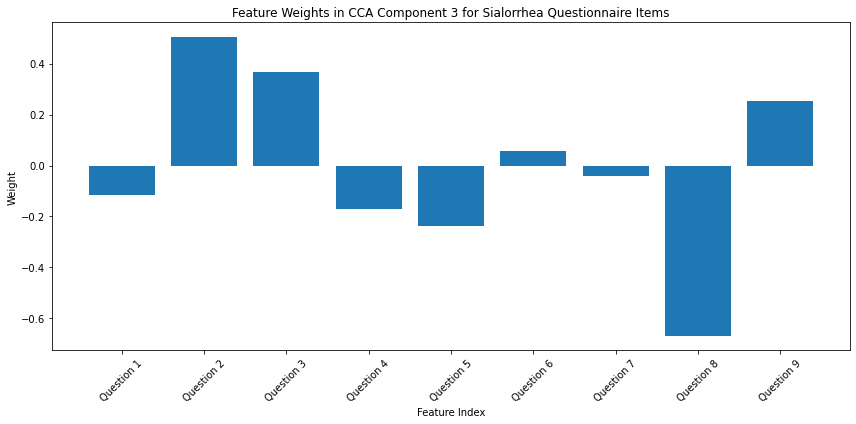

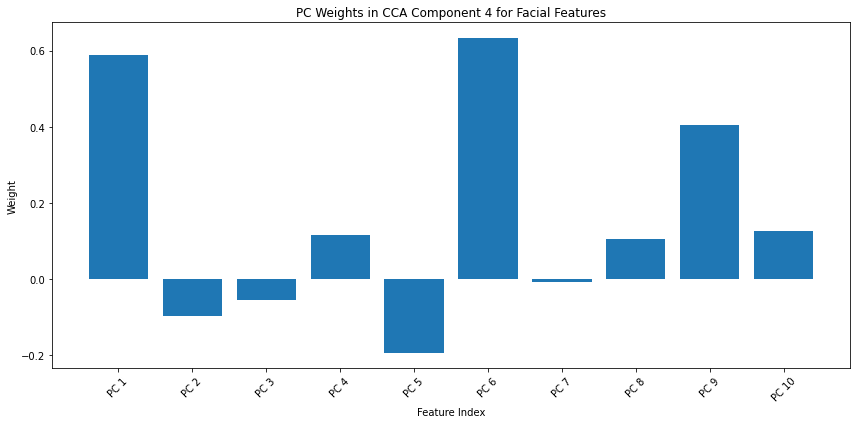

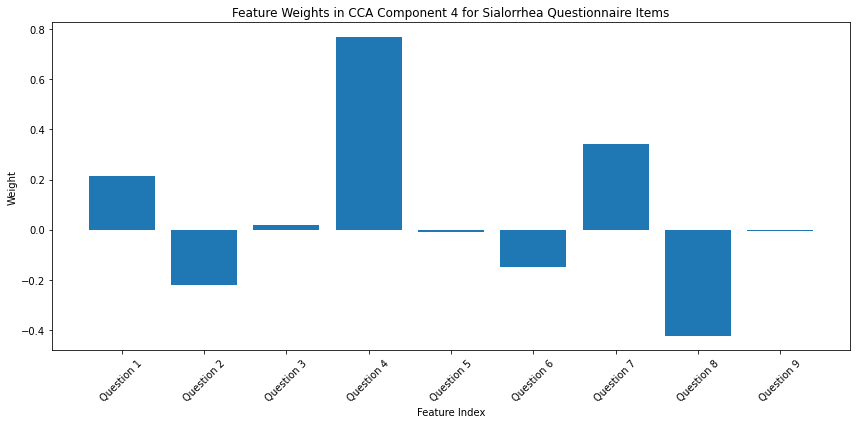

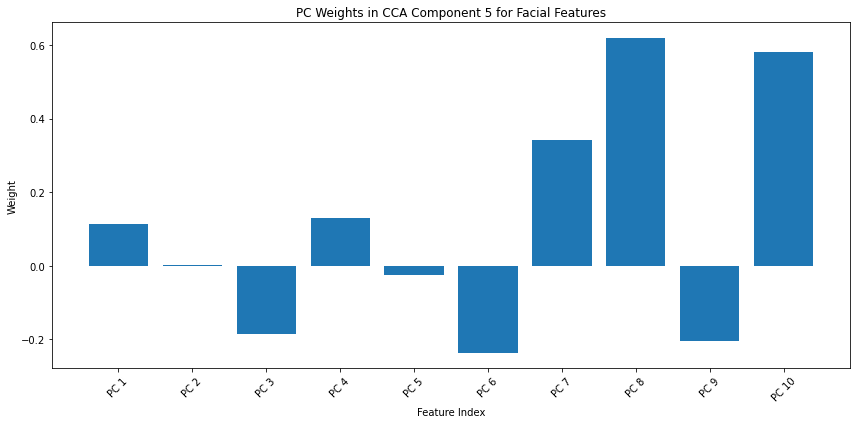

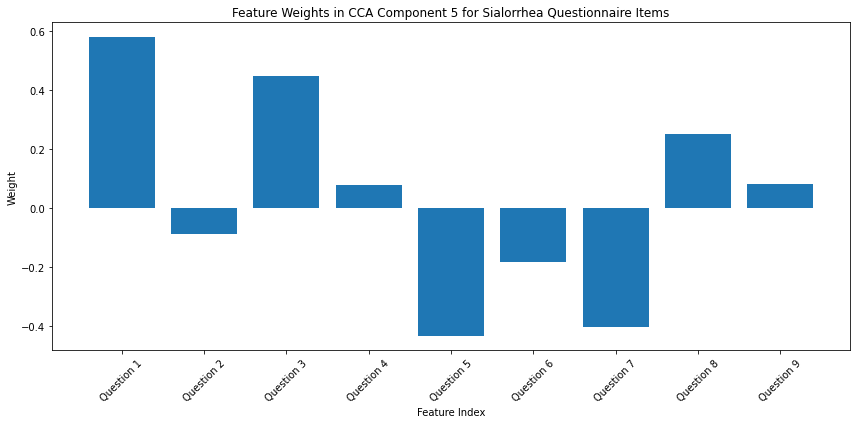

In [28]:
#print cca score
print(f'CCA Score: {cca.score( X_eye, Y)}')
show_loadings(cca.x_loadings_, cca.y_loadings_)

#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_weights_[:, component_index]
    weights_y = cca.y_weights_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()

# Part4: Analysis of all features (mouth, nose, eyes)

In [29]:
all_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\all_features_10_true_neutral_2.csv'
all_neutral_df = read_csv_features(all_features_csv)
all_features_csv = '\\\\files.ubc.ca\\team\\PPRC\\Camera\\Video Assessment_Atefeh\\sialorrhea\\all_features_10_max_happiness_2.csv'
all_happy_df = read_csv_features(all_features_csv)
combine_all_features_df = compute_combined_features(all_happy_df, all_neutral_df)
# Assuming 'participant_id' in combine_features_df corresponds to 'id' in saliva_df
merged_all_df = combine_all_features_df.join(saliva_df, how='inner', rsuffix='_saliva')

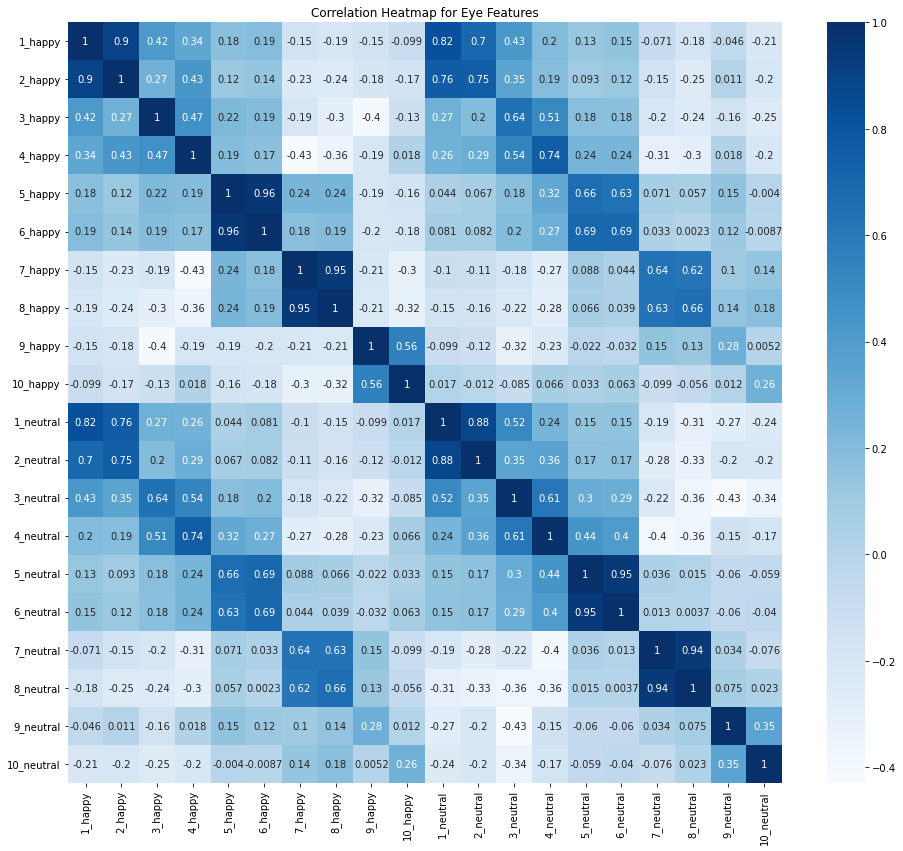

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix
correlation_matrix = combine_all_features_df.corr()

# Create the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=True, cmap='Blues')
plt.title('Correlation Heatmap for Eye Features')
plt.show()

In [31]:
#Define data
# Initialize the standard scaler
scaler = StandardScaler()

# Fit and transform the data
Y = scaler.fit_transform(merged_all_df.iloc[:, -9:])  # Features
X_all = scaler.fit_transform(merged_all_df.iloc[:, :-10])  # Questionnaire results

#Apply feature selection
pca_all = PCA(n_components=0.95)

X_all = pca_all.fit_transform(X_eye)

Average correlations across bootstrap samples: [0.87581157 0.78851821 0.69858697 0.59001162 0.47749244]
Standard deviation of correlations across bootstrap samples: [0.04385755 0.05491782 0.0591616  0.06769834 0.07266897]


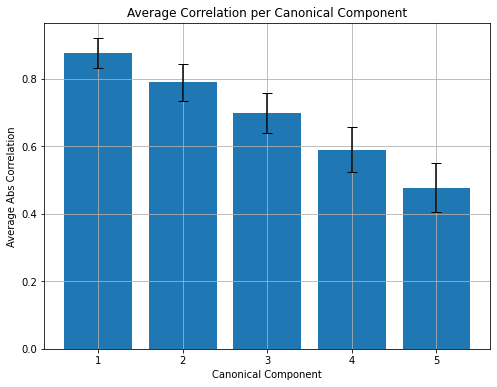

In [32]:
import numpy as np
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample



n_bootstraps = 1000
n_components = 5

average_correlations, std_correlations = bootstrap_analysis(X_all,Y,n_components, n_bootstraps)
# Plot the average correlations
plt.figure(figsize=(8, 6))
# plot bar plot with error bars
plt.bar(range(1, n_components+1), average_correlations, yerr=std_correlations, capsize=5)
plt.xlabel('Canonical Component')
plt.ylabel('Average Abs Correlation')
plt.title('Average Correlation per Canonical Component')
plt.grid(True)

In [33]:
# Fit CCA on the entire dataset using the average number of components
cca = CCA(n_components=5)
cca.fit(X_all, Y)

# Transform the data to get canonical variables
X_c, Y_c = cca.transform(X_all, Y)

Correlation for pair 1: 0.7221027000559386, P-value: 1.0441235860069026e-09


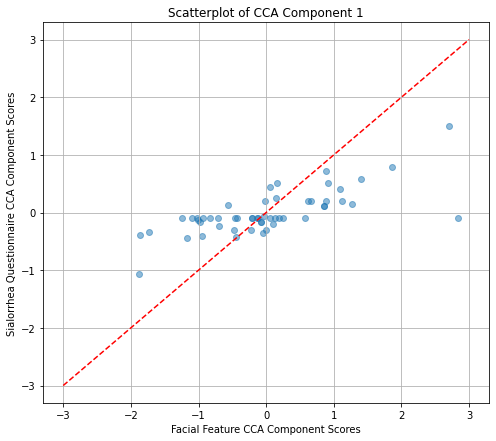

Correlation for pair 2: 0.665038109252115, P-value: 5.585705511341584e-08


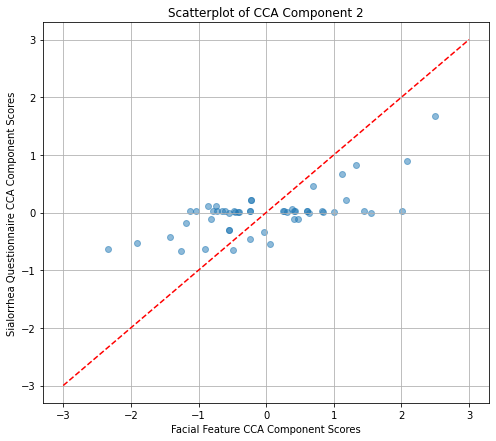

Correlation for pair 3: 0.6261254540261996, P-value: 5.325795615099625e-07


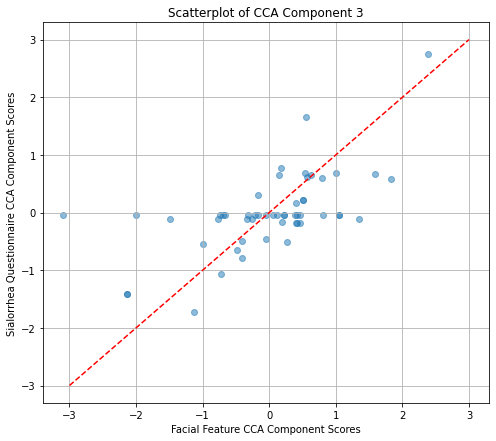

Correlation for pair 4: 0.47152841465628537, P-value: 0.0003652219574161183


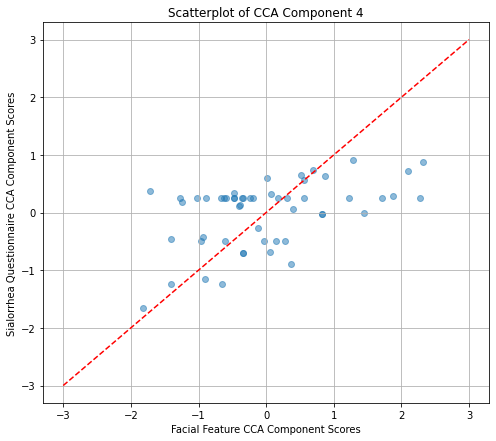

Correlation for pair 5: 0.3916029601287497, P-value: 0.0037349815583799526


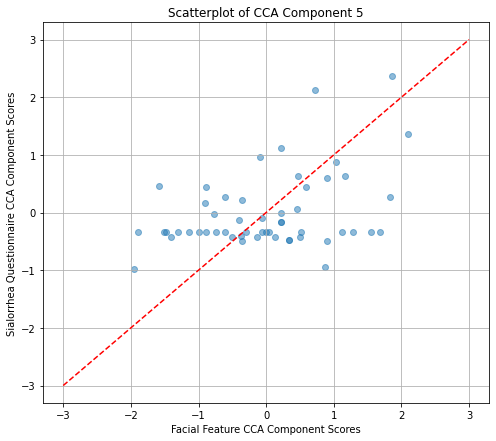

In [34]:
import matplotlib.pyplot as plt

# Number of components to plot
n_components_to_plot = X_c.shape[1]

for i in range(n_components_to_plot):
    corr, p_value = pearsonr(X_c[:, i], Y_c[:, i])
    print(f"Correlation for pair {i+1}: {corr}, P-value: {p_value}")
    plt.figure(figsize=(8,7))
    plt.scatter(X_c[:, i], Y_c[:, i], alpha=0.5)
    #plot x=y line
    plt.plot(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100), color='red', linestyle='--')
    plt.title(f'Scatterplot of CCA Component {i+1}')
    plt.xlabel('Facial Feature CCA Component Scores')
    plt.ylabel('Sialorrhea Questionnaire CCA Component Scores')
    plt.grid(True)
    plt.show()

CCA Score: -1.281680828427496


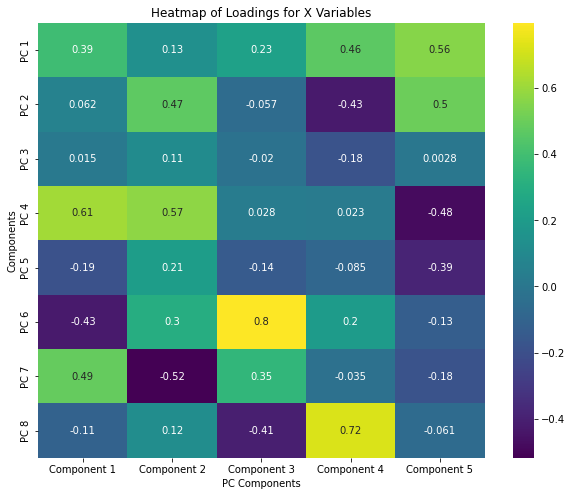

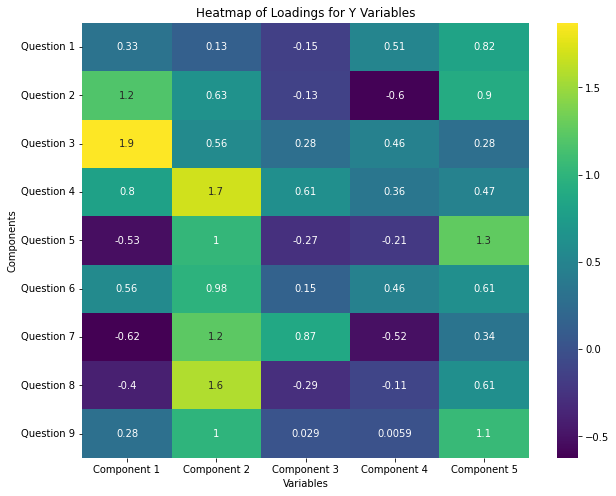

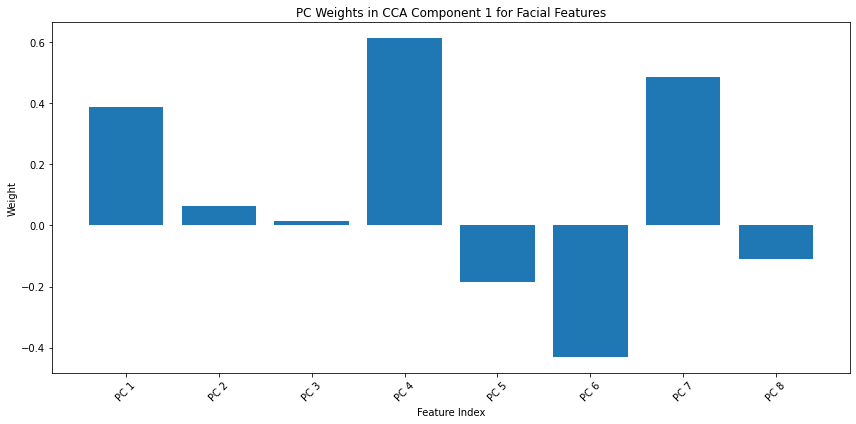

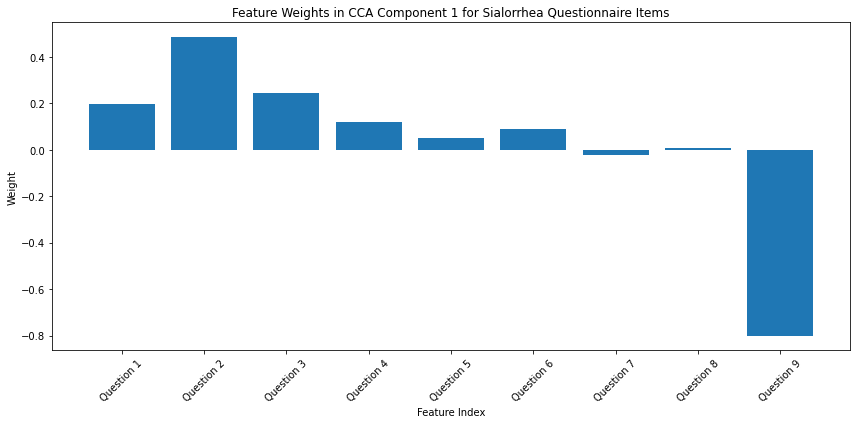

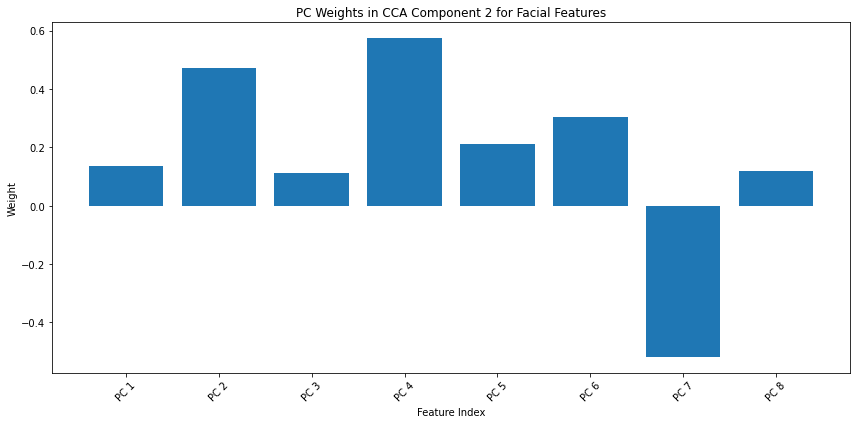

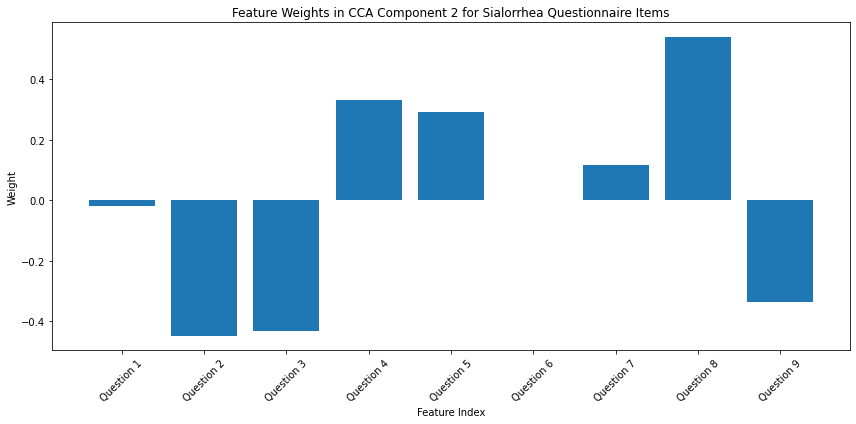

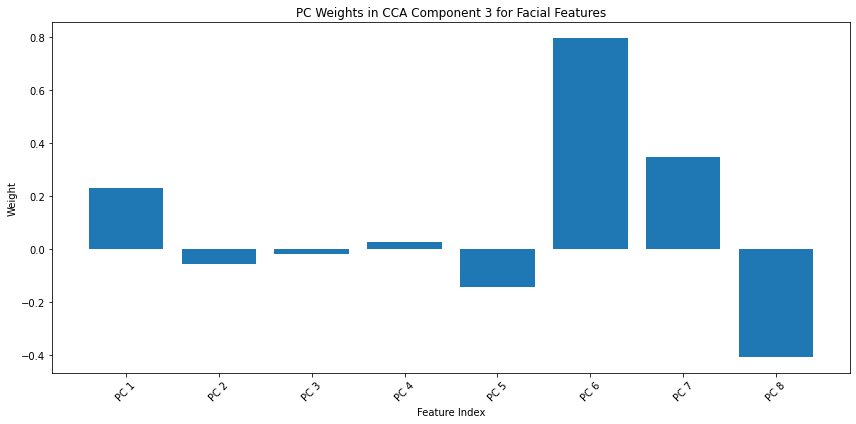

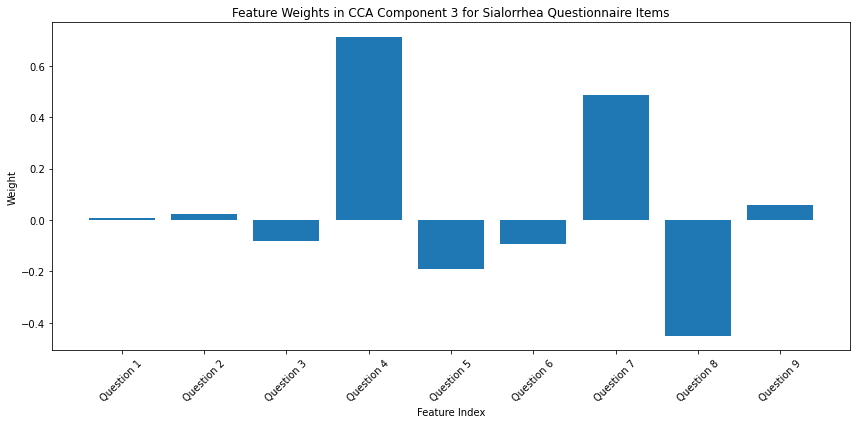

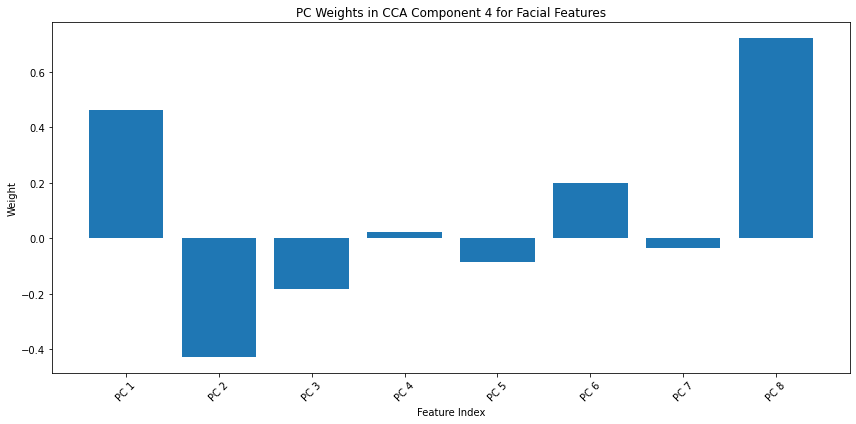

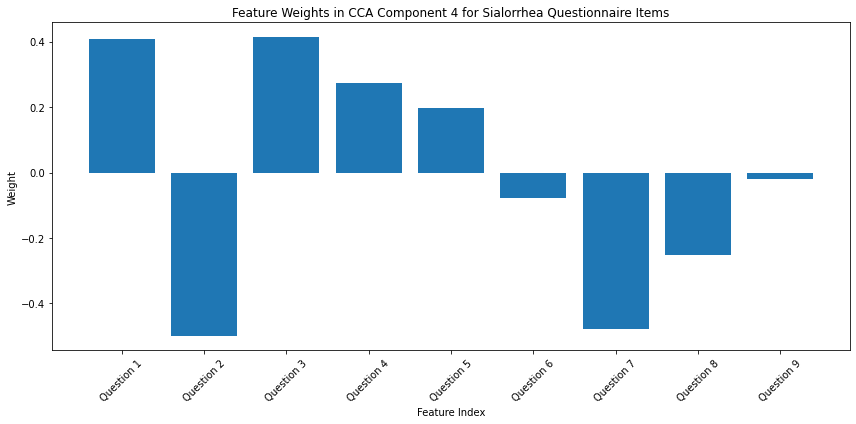

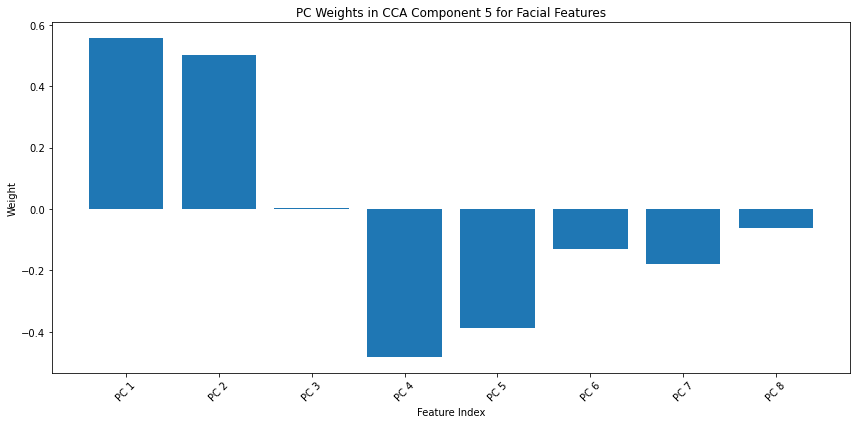

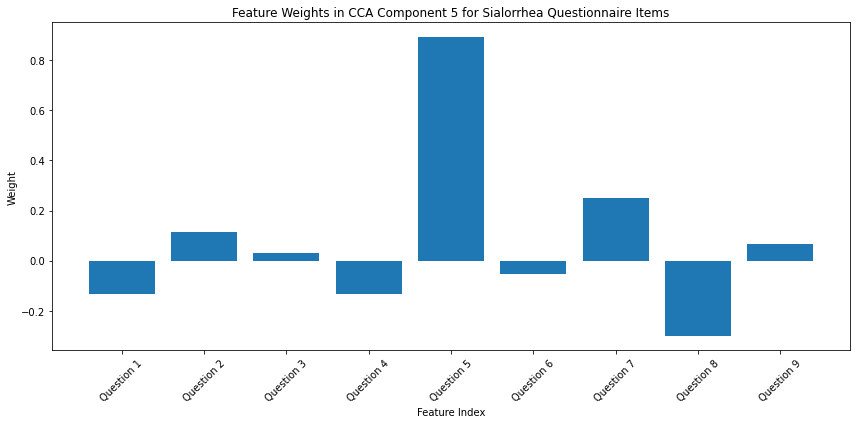

In [35]:
#print cca score
print(f'CCA Score: {cca.score( X_all, Y)}')
show_loadings(cca.x_loadings_, cca.y_loadings_)

#The left and right singular vectors of the cross-covariance matrices of X and Y
import matplotlib.pyplot as plt


for component_index in range(n_components_to_plot):
    # Extracting weights for the component
    weights_x = cca.x_weights_[:, component_index]
    weights_y = cca.y_weights_[:, component_index]

    # Plotting for X features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_x)), weights_x)
    plt.title(f'PC Weights in CCA Component {component_index+1} for Facial Features')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_x)), [f'PC {i+1}' for i in range(len(weights_x))], rotation=45)
    plt.tight_layout()
    plt.show()

    # Plotting for Y features
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(weights_y)), weights_y)
    plt.title(f'Feature Weights in CCA Component {component_index+1} for Sialorrhea Questionnaire Items')
    plt.xlabel('Feature Index')
    plt.ylabel('Weight')
    plt.xticks(range(len(weights_y)), [f'Question {i+1}' for i in range(len(weights_y))], rotation=45)
    plt.tight_layout()
    plt.show()

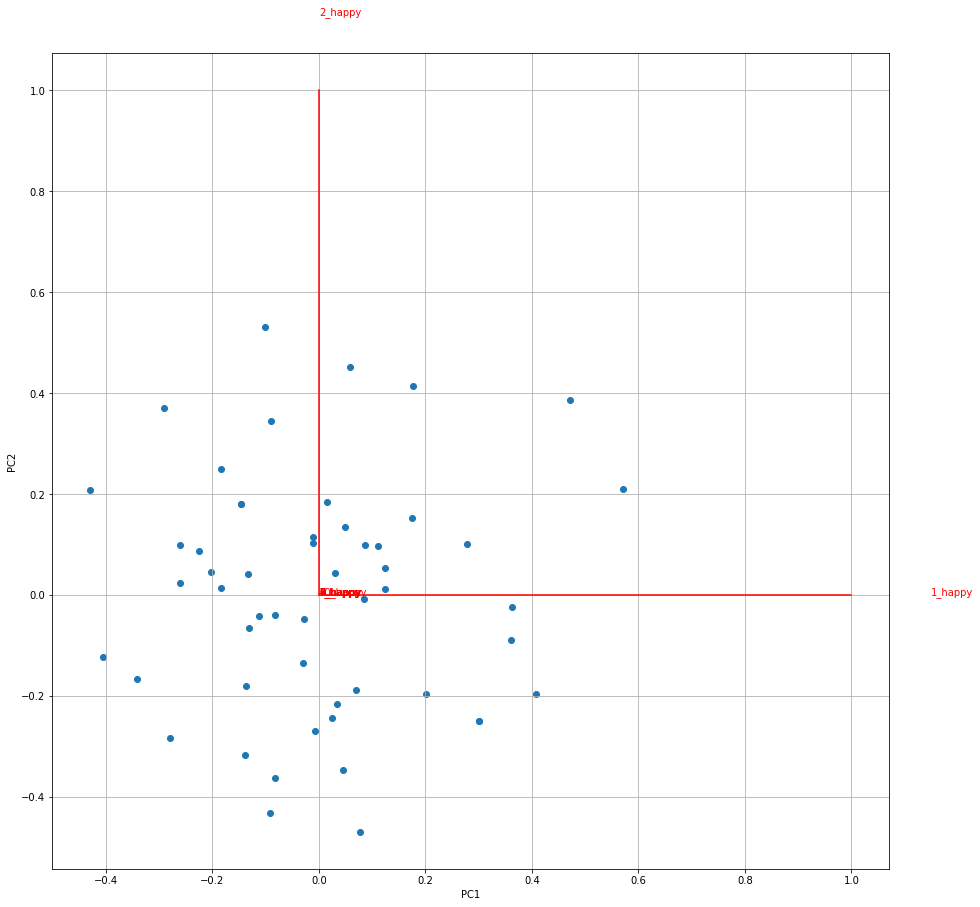

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Creating a biplot
def biplot(score, coeff, labels=None):
    xs = score[:,0]
    ys = score[:,1]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    
    fig = plt.figure(figsize=(15, 15))
    plt.scatter(xs * scalex, ys * scaley)
    
    for i in range(len(coeff)):
        x, y = coeff[i,0], coeff[i,1]
        plt.plot([0, x], [0, y], 'r-')
        if labels is None:
            plt.text(x* 1.15, y * 1.15, "Var"+str(i+1), color='r')
        else:
            plt.text(x* 1.15, y * 1.15, labels[i], color='r')

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.grid()

# Call the biplot function
biplot(X_all, np.transpose(pca_all.components_),merged_all_df.columns[0:-10])
plt.show()
